In [1]:
# import here
import pickle
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.utils.data.sampler as sampler
from torch import nn, optim
import torch.nn.functional as F
%matplotlib inline

---
# Load The Data

In [2]:
# Load pickled data
training_file = "data/train.p"
validation_file = "data/valid.p"
testing_file = "data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

# Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

In [3]:
# Number of training examples
n_train = len(X_train)
# Number of validation examples.
n_valid = len(X_valid)
# Number of testing examples.
n_test = len(X_test)

# The shape of an traffic sign image
image_shape = X_train[0].shape[:-1]

# Number of unique classes/labels in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


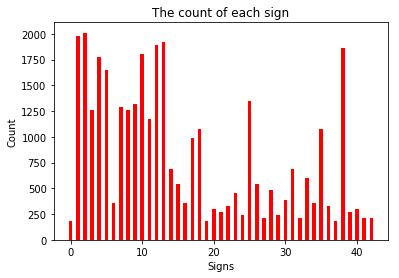

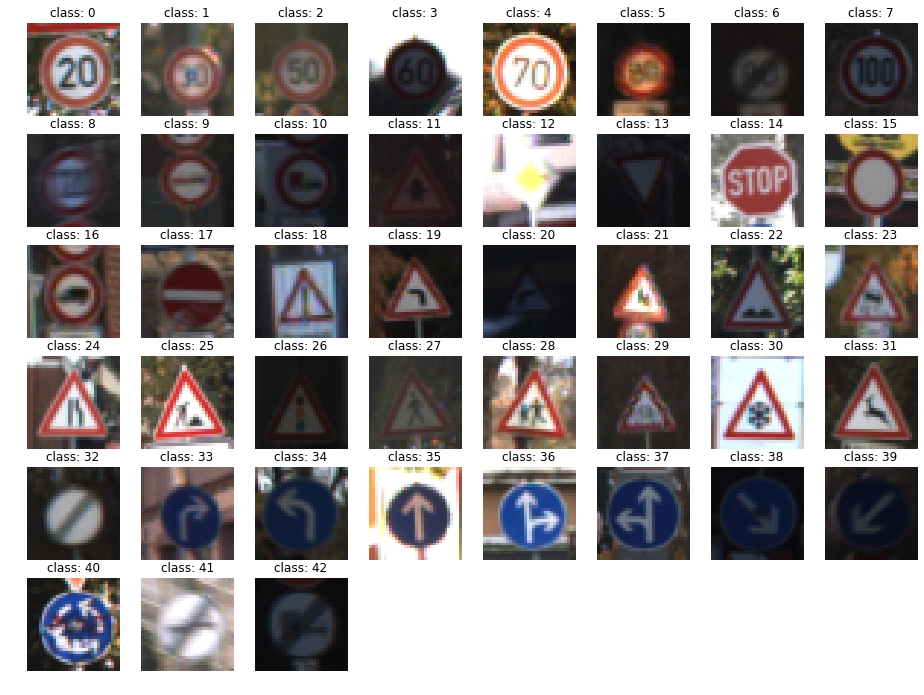

In [4]:
### Data exploration visualization.
fig, ax = plt.subplots()
ax.bar(range(n_classes), np.bincount(y_train), 0.5, color='r')
ax.set_xlabel('Signs')
ax.set_ylabel('Count')
ax.set_title('The count of each sign')
plt.show()

plt.figure(figsize=(16, 16))
for c in range(n_classes):
    i = random.choice(np.where(y_train == c)[0])
    plt.subplot(8, 8, c+1)
    plt.axis('off')
    plt.title('class: {}'.format(c))
    plt.imshow(X_train[i])

----

# Design and Test a Baseline Model Architecture

## Custom Dataset & DataLoader

In [5]:
class PickledDataset(Dataset):
    def __init__(self, file_path, transform=None):
        with open(file_path, mode='rb') as f:
            data = pickle.load(f)
            self.features = data['features']
            self.labels = data['labels']
            self.count = len(self.labels)
            self.transform = transform
        
    def __getitem__(self, index):
        feature = self.features[index]
        if self.transform is not None:
            feature = self.transform(feature)
        return (feature, self.labels[index])

    def __len__(self):
        return self.count

In [6]:
class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

## Baseline Model

In [7]:
class BaselineNet(nn.Module):
    def __init__(self, gray=False):
        super(BaselineNet, self).__init__()
        input_chan = 1 if gray else 3
        self.conv1 = nn.Conv2d(input_chan, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 43)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Training

In [8]:
torch.manual_seed(1)

In [10]:
train_dataset = PickledDataset(training_file, transform=transforms.ToTensor())
valid_dataset = PickledDataset(validation_file, transform=transforms.ToTensor())
test_dataset = PickledDataset(testing_file, transform=transforms.ToTensor())

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def preprocess(x, y):
    return x.to(device), y.to(device, dtype=torch.int64)

train_loader = WrappedDataLoader(train_loader, preprocess)
valid_loader = WrappedDataLoader(valid_loader, preprocess)
test_loader = WrappedDataLoader(test_loader, preprocess)

In [12]:
model = BaselineNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
n_epochs = 20

In [21]:
def loss_batch(model, loss_func, x, y, opt=None):
    loss = loss_func(model(x), y)
    
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(x)

In [22]:
def valid_batch(model, loss_func, x, y):
    output = model(x)
    loss = loss_func(output, y)
    pred = torch.argmax(output, dim=1)
    correct = pred == y.view(*pred.shape)
    
    return loss.item(), torch.sum(correct).item(), len(x)

In [23]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        # Train model
        model.train()
        losses, nums = zip(*[loss_batch(model, loss_func, x, y, opt) for x, y in train_dl])
        train_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        # Validation model
        model.eval()
        with torch.no_grad():
            losses, corrects, nums = zip(*[valid_batch(model, loss_func, x, y) for x, y in valid_dl])
            valid_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
            valid_accuracy = np.sum(corrects) / np.sum(nums) * 100
            print(f"[Epoch {epoch+1}/{epochs}] "
                  f"Train loss: {train_loss:.6f}\t"
                  f"Validation loss: {valid_loss:.6f}\t",
                  f"Validation accruacy: {valid_accuracy:.3f}%")

In [16]:
def evaluate(model, loss_func, dl):
    model.eval()
    with torch.no_grad():
        losses, corrects, nums = zip(*[valid_batch(model, loss_func, x, y) for x, y in dl])
        test_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        test_accuracy = np.sum(corrects) / np.sum(nums) * 100
        
    print(f"Test loss: {test_loss:.6f}\t"
          f"Test accruacy: {test_accuracy:.3f}%")

In [16]:
fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)
evaluate(model, criterion, test_loader)

[Epoch 1/20] Train loss: 3.675418	Validation loss: 3.591742	 Validation accruacy: 5.578%
[Epoch 2/20] Train loss: 3.484762	Validation loss: 3.570412	 Validation accruacy: 5.873%
[Epoch 3/20] Train loss: 3.457656	Validation loss: 3.540311	 Validation accruacy: 6.281%
[Epoch 4/20] Train loss: 3.341224	Validation loss: 3.351182	 Validation accruacy: 17.166%
[Epoch 5/20] Train loss: 2.716729	Validation loss: 2.373092	 Validation accruacy: 37.143%
[Epoch 6/20] Train loss: 1.721432	Validation loss: 1.628617	 Validation accruacy: 53.333%
[Epoch 7/20] Train loss: 1.146925	Validation loss: 1.174271	 Validation accruacy: 66.712%
[Epoch 8/20] Train loss: 0.857095	Validation loss: 0.980455	 Validation accruacy: 72.109%
[Epoch 9/20] Train loss: 0.679140	Validation loss: 0.982687	 Validation accruacy: 71.837%
[Epoch 10/20] Train loss: 0.564483	Validation loss: 0.822770	 Validation accruacy: 77.166%
[Epoch 11/20] Train loss: 0.476158	Validation loss: 0.724351	 Validation accruacy: 79.841%
[Epoch 12/2

---
# Experiment and find tuning

## Data preprocessing

### Image normalize

In [17]:
# Channel separation
red_chan = np.reshape(X_train[:,:,:,0], -1)/255
green_chan = np.reshape(X_train[:,:,:,1], -1)/255
blue_chan = np.reshape(X_train[:,:,:,2], -1)/255

# mean
means = [np.mean(red_chan), np.mean(green_chan), np.mean(blue_chan)]

# std
stds = [np.std(red_chan), np.std(green_chan), np.std(blue_chan)]

print(means)
print(stds)

[0.3399926354902852, 0.31174878670783124, 0.32093609588419364]
[0.2717014855590075, 0.2598821025549765, 0.26575037442309596]


In [18]:
# Add normalize
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.3340, 0.3117, 0.3209), (0.2717, 0.2599, 0.2658))
])

train_dataset = PickledDataset(training_file, transform=data_transforms)
valid_dataset = PickledDataset(validation_file, transform=data_transforms)
test_dataset = PickledDataset(testing_file, transform=data_transforms)

train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, shuffle=True), preprocess)
valid_loader = WrappedDataLoader(DataLoader(valid_dataset, batch_size=64, shuffle=False), preprocess)
test_loader = WrappedDataLoader(DataLoader(test_dataset, batch_size=64, shuffle=False), preprocess)

In [19]:
model = BaselineNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)
evaluate(model, criterion, test_loader)

[Epoch 1/20] Train loss: 3.595845	Validation loss: 3.536752	 Validation accruacy: 8.390%
[Epoch 2/20] Train loss: 3.103077	Validation loss: 2.891620	 Validation accruacy: 29.615%
[Epoch 3/20] Train loss: 2.062854	Validation loss: 1.870797	 Validation accruacy: 49.955%
[Epoch 4/20] Train loss: 1.136665	Validation loss: 1.136178	 Validation accruacy: 66.712%
[Epoch 5/20] Train loss: 0.710390	Validation loss: 0.904368	 Validation accruacy: 72.358%
[Epoch 6/20] Train loss: 0.501730	Validation loss: 0.733819	 Validation accruacy: 80.091%
[Epoch 7/20] Train loss: 0.381315	Validation loss: 0.740885	 Validation accruacy: 80.907%
[Epoch 8/20] Train loss: 0.309576	Validation loss: 0.719398	 Validation accruacy: 80.816%
[Epoch 9/20] Train loss: 0.254943	Validation loss: 0.654069	 Validation accruacy: 82.698%
[Epoch 10/20] Train loss: 0.216248	Validation loss: 0.678800	 Validation accruacy: 82.426%
[Epoch 11/20] Train loss: 0.182795	Validation loss: 0.664365	 Validation accruacy: 84.104%
[Epoch 12

### Contrast-limited adaptive histogram equalization

In [20]:
class CLAHE:
    def __init__(self, clipLimit=2.0, tileGridSize=(8, 8)):
        self.clipLimit = clipLimit
        self.tileGridSize = tileGridSize

    def __call__(self, im):
        img_yuv = cv2.cvtColor(im, cv2.COLOR_RGB2YUV)
        clahe = cv2.createCLAHE(clipLimit=self.clipLimit, tileGridSize=self.tileGridSize)
        img_yuv[:, :, 0] = clahe.apply(img_yuv[:, :, 0])
        img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
        return img_output
    
class CLAHE_RGB:
    def __init__(self, clipLimit=2.0, tileGridSize=(8, 8)):
        self.clipLimit = clipLimit
        self.tileGridSize = tileGridSize
        
    def __call__(self, im):
        r,g,b = cv2.split(im)
        clahe = cv2.createCLAHE(clipLimit=self.clipLimit, tileGridSize=self.tileGridSize)
        r,g,b = clahe.apply(r), clahe.apply(g), clahe.apply(b)
        return cv2.merge([r,g,b])

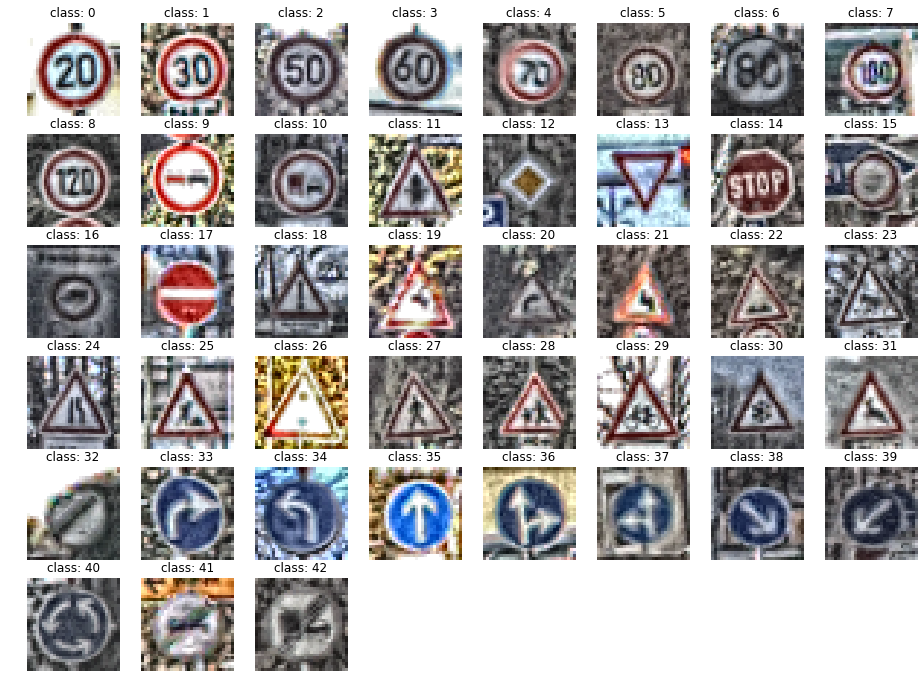

In [21]:
clahe = CLAHE()
plt.figure(figsize=(16, 16))
for c in range(n_classes):
    i = random.choice(np.where(y_train == c)[0])
    plt.subplot(8, 8, c+1)
    plt.axis('off')
    plt.title('class: {}'.format(c))
    plt.imshow(clahe(X_train[i]))

In [22]:
# Apply CLAHE
X_train_clahe = np.array([clahe(x) for x in X_train])

# Channel separation
red_chan = np.reshape(X_train_clahe[:,:,:,0], -1)/255
green_chan = np.reshape(X_train_clahe[:,:,:,1], -1)/255
blue_chan = np.reshape(X_train_clahe[:,:,:,2], -1)/255

# mean
means = [np.mean(red_chan), np.mean(green_chan), np.mean(blue_chan)]

# std
stds = [np.std(red_chan), np.std(green_chan), np.std(blue_chan)]

print(means)
print(stds)

[0.48979965188475316, 0.4619486133805039, 0.47077281421203754]
[0.2475561430858259, 0.24408226795115162, 0.25143887243189583]


In [25]:
data_transforms = transforms.Compose([
    CLAHE(),
    transforms.ToTensor(),
    transforms.Normalize((0.4898, 0.4619, 0.4708), (0.2476, 0.2441, 0.2514))
])

train_dataset = PickledDataset(training_file, transform=data_transforms)
valid_dataset = PickledDataset(validation_file, transform=data_transforms)
test_dataset = PickledDataset(testing_file, transform=data_transforms)

train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4), preprocess)
valid_loader = WrappedDataLoader(DataLoader(valid_dataset, batch_size=64, shuffle=False, num_workers=4), preprocess)
test_loader = WrappedDataLoader(DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4), preprocess)

In [26]:
model = BaselineNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)
evaluate(model, criterion, test_loader)

[Epoch 1/20] Train loss: 3.591187	Validation loss: 3.472025	 Validation accruacy: 5.442%
[Epoch 2/20] Train loss: 2.566384	Validation loss: 1.382126	 Validation accruacy: 61.202%
[Epoch 3/20] Train loss: 0.754889	Validation loss: 0.601190	 Validation accruacy: 81.905%
[Epoch 4/20] Train loss: 0.374415	Validation loss: 0.409011	 Validation accruacy: 87.596%
[Epoch 5/20] Train loss: 0.248165	Validation loss: 0.383546	 Validation accruacy: 88.594%
[Epoch 6/20] Train loss: 0.180954	Validation loss: 0.314023	 Validation accruacy: 90.658%
[Epoch 7/20] Train loss: 0.143878	Validation loss: 0.303716	 Validation accruacy: 91.179%
[Epoch 8/20] Train loss: 0.116549	Validation loss: 0.277627	 Validation accruacy: 91.973%
[Epoch 9/20] Train loss: 0.096356	Validation loss: 0.259180	 Validation accruacy: 92.744%
[Epoch 10/20] Train loss: 0.080828	Validation loss: 0.247383	 Validation accruacy: 92.857%
[Epoch 11/20] Train loss: 0.073739	Validation loss: 0.252067	 Validation accruacy: 93.288%
[Epoch 12

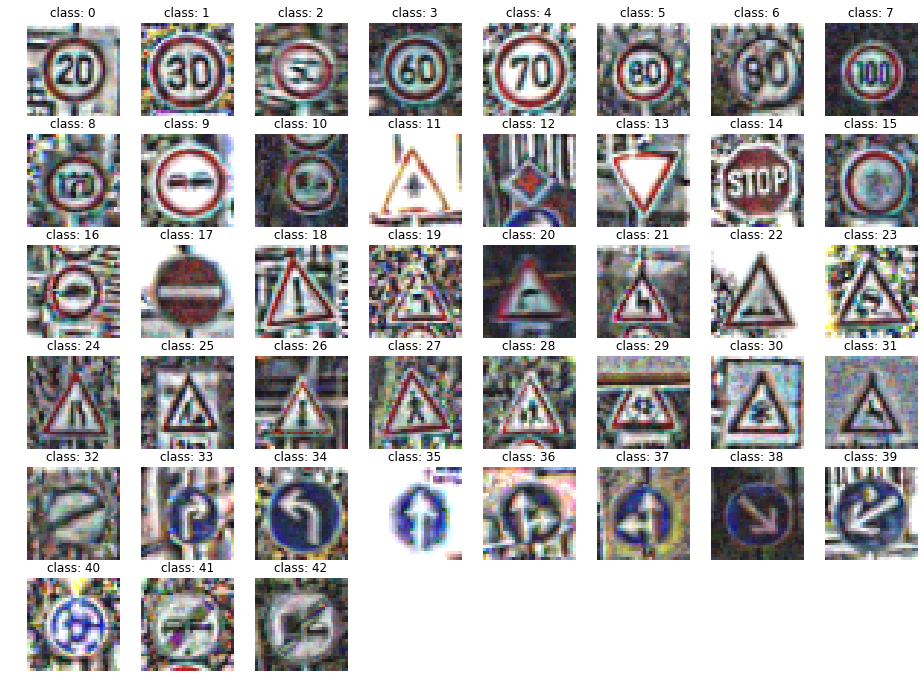

In [27]:
clahe = CLAHE_RGB()
plt.figure(figsize=(16, 16))
for c in range(n_classes):
    i = random.choice(np.where(y_train == c)[0])
    plt.subplot(8, 8, c+1)
    plt.axis('off')
    plt.title('class: {}'.format(c))
    plt.imshow(clahe(X_train[i]))

In [28]:
# Apply CLAHE
X_train_clahe = np.array([clahe(x) for x in X_train])

# Channel separation
red_chan = np.reshape(X_train_clahe[:,:,:,0], -1)/255
green_chan = np.reshape(X_train_clahe[:,:,:,1], -1)/255
blue_chan = np.reshape(X_train_clahe[:,:,:,2], -1)/255

# mean
means = [np.mean(red_chan), np.mean(green_chan), np.mean(blue_chan)]

# std
stds = [np.std(red_chan), np.std(green_chan), np.std(blue_chan)]

print(means)
print(stds)

[0.48207543769657635, 0.47128546659097925, 0.4800727286603284]
[0.24111850691156145, 0.2442877895339099, 0.2438385451964827]


In [29]:
data_transforms = transforms.Compose([
    CLAHE_RGB(),
    transforms.ToTensor(),
    transforms.Normalize((0.4821, 0.4713, 0.4801), (0.2411, 0.2443, 0.2438))
])

train_dataset = PickledDataset(training_file, transform=data_transforms)
valid_dataset = PickledDataset(validation_file, transform=data_transforms)
test_dataset = PickledDataset(testing_file, transform=data_transforms)

train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4), preprocess)
valid_loader = WrappedDataLoader(DataLoader(valid_dataset, batch_size=64, shuffle=False, num_workers=4), preprocess)
test_loader = WrappedDataLoader(DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4), preprocess)

In [30]:
model = BaselineNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)
evaluate(model, criterion, test_loader)

[Epoch 1/20] Train loss: 3.472728	Validation loss: 3.094450	 Validation accruacy: 24.218%
[Epoch 2/20] Train loss: 1.538369	Validation loss: 0.795785	 Validation accruacy: 76.122%
[Epoch 3/20] Train loss: 0.520861	Validation loss: 0.478390	 Validation accruacy: 86.417%
[Epoch 4/20] Train loss: 0.323412	Validation loss: 0.378769	 Validation accruacy: 88.957%
[Epoch 5/20] Train loss: 0.231039	Validation loss: 0.373377	 Validation accruacy: 88.639%
[Epoch 6/20] Train loss: 0.180154	Validation loss: 0.312862	 Validation accruacy: 90.794%
[Epoch 7/20] Train loss: 0.139881	Validation loss: 0.270064	 Validation accruacy: 92.630%
[Epoch 8/20] Train loss: 0.116487	Validation loss: 0.295914	 Validation accruacy: 91.723%
[Epoch 9/20] Train loss: 0.096471	Validation loss: 0.286064	 Validation accruacy: 91.610%
[Epoch 10/20] Train loss: 0.082353	Validation loss: 0.262534	 Validation accruacy: 92.358%
[Epoch 11/20] Train loss: 0.071124	Validation loss: 0.269468	 Validation accruacy: 92.290%
[Epoch 1

### Grayscale

In [17]:
class CLAHE_GRAY:
    def __init__(self, clipLimit=2.0, tileGridSize=(8, 8)):
        self.clipLimit = clipLimit
        self.tileGridSize = tileGridSize

    def __call__(self, im):
        img_y = cv2.cvtColor(im, cv2.COLOR_RGB2YUV)[:,:,0]
        clahe = cv2.createCLAHE(clipLimit=self.clipLimit, tileGridSize=self.tileGridSize)
        img_y = clahe.apply(img_y)
        img_output = img_y.reshape(img_y.shape + (1,))
        return img_output

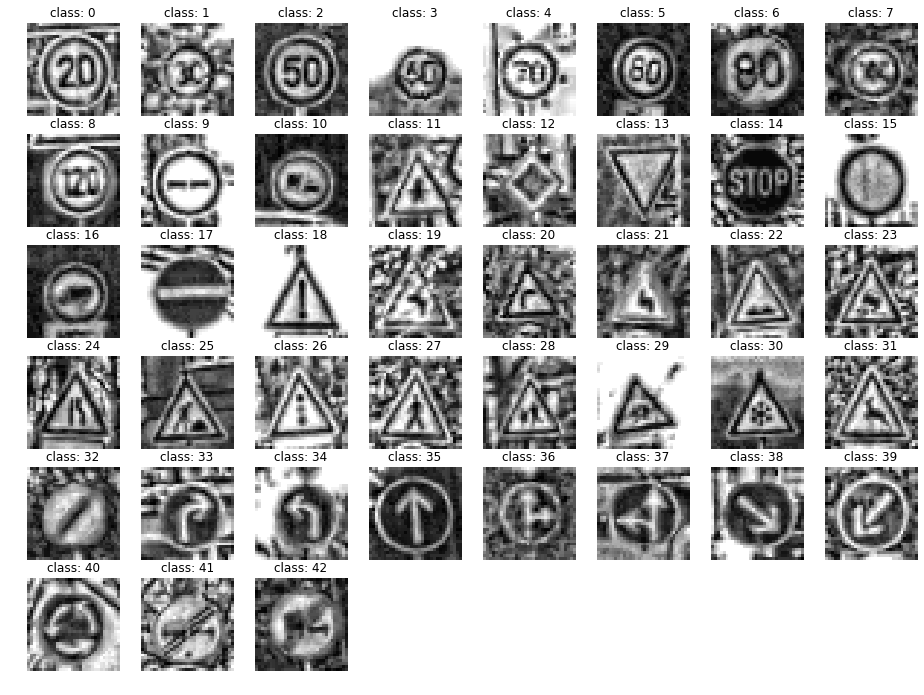

In [50]:
clahe = CLAHE_GRAY()
plt.figure(figsize=(16, 16))
for c in range(n_classes):
    i = random.choice(np.where(y_train == c)[0])
    plt.subplot(8, 8, c+1)
    plt.axis('off')
    plt.title('class: {}'.format(c))    
    plt.imshow(clahe(X_train[i]).squeeze(), cmap='gray')

In [51]:
# Apply CLAHE
X_train_clahe = np.array([clahe(x) for x in X_train])

gray_chan = np.reshape(X_train_clahe[:,:,:,0], -1)/255
print(np.mean(gray_chan))
print(np.std(gray_chan))

0.4714577090373069
0.24148300871438033


In [52]:
data_transforms = transforms.Compose([
    CLAHE_GRAY(),
    transforms.ToTensor(),
    transforms.Normalize((0.4715,),(0.2415,))
])

train_dataset = PickledDataset(training_file, transform=data_transforms)
valid_dataset = PickledDataset(validation_file, transform=data_transforms)
test_dataset = PickledDataset(testing_file, transform=data_transforms)

train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4), preprocess)
valid_loader = WrappedDataLoader(DataLoader(valid_dataset, batch_size=64, shuffle=False, num_workers=4), preprocess)
test_loader = WrappedDataLoader(DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4), preprocess)

In [53]:
model = BaselineNet(gray=True).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)
evaluate(model, criterion, test_loader)

[Epoch 1/20] Train loss: 3.543211	Validation loss: 3.482467	 Validation accruacy: 9.320%
[Epoch 2/20] Train loss: 2.786990	Validation loss: 1.855021	 Validation accruacy: 46.508%
[Epoch 3/20] Train loss: 1.103442	Validation loss: 0.830158	 Validation accruacy: 75.057%
[Epoch 4/20] Train loss: 0.543559	Validation loss: 0.620322	 Validation accruacy: 81.134%
[Epoch 5/20] Train loss: 0.336729	Validation loss: 0.480551	 Validation accruacy: 86.009%
[Epoch 6/20] Train loss: 0.242435	Validation loss: 0.416722	 Validation accruacy: 88.934%
[Epoch 7/20] Train loss: 0.193920	Validation loss: 0.381791	 Validation accruacy: 89.184%
[Epoch 8/20] Train loss: 0.156449	Validation loss: 0.334260	 Validation accruacy: 90.476%
[Epoch 9/20] Train loss: 0.133035	Validation loss: 0.317022	 Validation accruacy: 92.041%
[Epoch 10/20] Train loss: 0.114732	Validation loss: 0.318523	 Validation accruacy: 91.882%
[Epoch 11/20] Train loss: 0.100091	Validation loss: 0.268389	 Validation accruacy: 92.948%
[Epoch 12

## Handling imbalanced dataset

In [18]:
# Use weighted sampler
class_sample_count = np.bincount(y_train)
weights = 1 / np.array([class_sample_count[y] for y in y_train])
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, 43 * 5000)

In [19]:
import PIL

# Data augmentation
train_data_transforms = transforms.Compose([
    CLAHE_GRAY(),
    transforms.ToPILImage(),
    transforms.RandomApply([
        transforms.RandomRotation(20, resample=PIL.Image.BICUBIC),
        transforms.RandomAffine(0, translate=(0.2, 0.2), resample=PIL.Image.BICUBIC),
        transforms.RandomAffine(0, shear=20, resample=PIL.Image.BICUBIC),
        transforms.RandomAffine(0, scale=(0.8, 1.2), resample=PIL.Image.BICUBIC)
    ]),
    transforms.ToTensor(),
    transforms.Normalize((0.4715,),(0.2415,))
])
test_data_transforms = transforms.Compose([
    CLAHE_GRAY(),
    transforms.ToTensor(),
    transforms.Normalize((0.4715,),(0.2415,))
])

train_dataset = PickledDataset(training_file, transform=train_data_transforms)
valid_dataset = PickledDataset(validation_file, transform=test_data_transforms)
test_dataset = PickledDataset(testing_file, transform=test_data_transforms)

train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, sampler=sampler, num_workers=4), preprocess)
valid_loader = WrappedDataLoader(DataLoader(valid_dataset, batch_size=64, shuffle=False, num_workers=4), preprocess)
test_loader = WrappedDataLoader(DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4), preprocess)

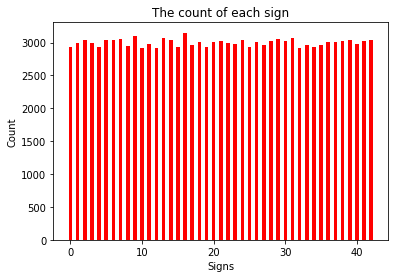

In [62]:
balacned_y_train = np.array([], dtype=np.int64)

with torch.no_grad():
    for _, y in train_loader:
        y = y.to(device, dtype=torch.int64)
        balacned_y_train = np.append(balacned_y_train, y.cpu().numpy())

fig, ax = plt.subplots()
ax.bar(range(n_classes), np.bincount(balacned_y_train), 0.5, color='r')
ax.set_xlabel('Signs')
ax.set_ylabel('Count')
ax.set_title('The count of each sign')
plt.show()

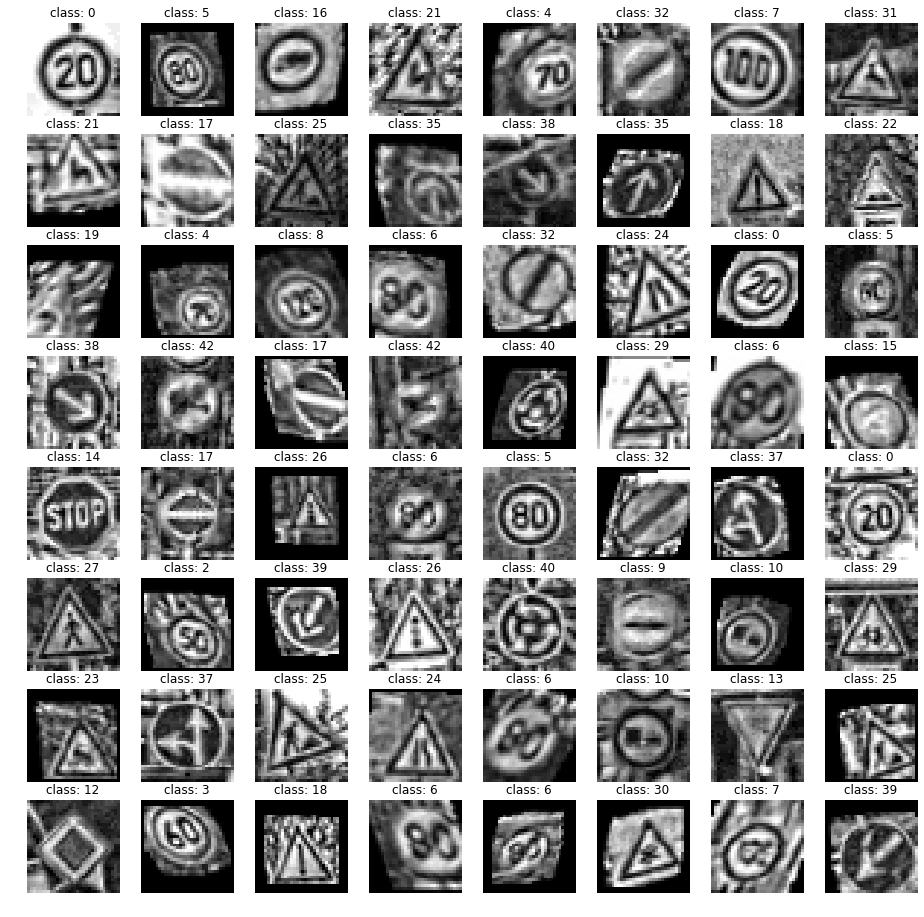

In [77]:
with torch.no_grad():
    x, y = next(iter(train_loader))
    x, y = x.to(device).cpu().numpy(), y.to(device).cpu().numpy()
    plt.figure(figsize=(16, 16))
    for i in range(len(y)):
        plt.subplot(8, 8, i+1)
        plt.axis('off')
        plt.title('class: {}'.format(y[i]))
        image = np.transpose(x[i], (1, 2, 0))
        mean = 0.4715
        std = 0.2415
        image = std * image + mean
        plt.imshow(np.array(image).squeeze(), cmap='gray')

In [82]:
model = BaselineNet(gray=True).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)
evaluate(model, criterion, test_loader)

[Epoch 1/20] Train loss: 3.134822	Validation loss: 1.272852	 Validation accruacy: 62.063%
[Epoch 2/20] Train loss: 1.264456	Validation loss: 0.496528	 Validation accruacy: 85.692%
[Epoch 3/20] Train loss: 0.774723	Validation loss: 0.336140	 Validation accruacy: 90.317%
[Epoch 4/20] Train loss: 0.583887	Validation loss: 0.292693	 Validation accruacy: 92.041%
[Epoch 5/20] Train loss: 0.474689	Validation loss: 0.268980	 Validation accruacy: 91.882%
[Epoch 6/20] Train loss: 0.413700	Validation loss: 0.276900	 Validation accruacy: 91.655%
[Epoch 7/20] Train loss: 0.367788	Validation loss: 0.240001	 Validation accruacy: 93.878%
[Epoch 8/20] Train loss: 0.331330	Validation loss: 0.210775	 Validation accruacy: 94.240%
[Epoch 9/20] Train loss: 0.304173	Validation loss: 0.221426	 Validation accruacy: 94.422%
[Epoch 10/20] Train loss: 0.284777	Validation loss: 0.230372	 Validation accruacy: 94.172%
[Epoch 11/20] Train loss: 0.265814	Validation loss: 0.193850	 Validation accruacy: 95.125%
[Epoch 1

## Pretrained model VS Custom model

## Spatial transformer networks